### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import subprocess
import os
from datetime import datetime
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingWarmRestarts
import torchvision
from torchvision import models
from apex import amp

from torch_lr_finder import LRFinder

from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import cv2
import skimage.io
import IPython.display as display
from PIL import Image

plt.ion()
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Local Imports

In [3]:
# Paths
from chestxray.config import (PANDA_PATH,
                              MODEL_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)
# Competition related config
from chestxray.config import CFG

# Misc
from chestxray.misc import seed_torch

# Datasets
from chestxray.datasets import get_transforms, TrainDataset, TilesTrainDataset, LazyTilesDataset, PatchTrainDataset, H5PatchDataset, SeqenceRandomSampler

# Viz
from chestxray.visualize import (show_from_ids, show_batch, imshow, 
                                 plot_classes_preds, reverse_show_img, 
                                 plot_confusion_matrix, text_classes_preds)

# Nets
from chestxray.nets import TinyV2ConvNet, freeze_botom, PatchModel, PatchEnetModel
from chestxray.model_utils import (trainable_params, cce_loss_at_init, 
                                   init_last_layer_bias)
# Losses
from chestxray.losses import LabelSmoothSoftmaxCEV1, TopkCrossEntropy

# Optim
from chestxray.optimizers import RAdam

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='GeForce RTX 2070 SUPER', major=7, minor=5, total_memory=7979MB, multi_processor_count=40)


### Fix Random Seed

In [6]:
seed_torch()

### Load Data

In [7]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)
TRAIN_DF.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [8]:
TRAIN_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
dtypes: int64(1), object(3)
memory usage: 331.9+ KB


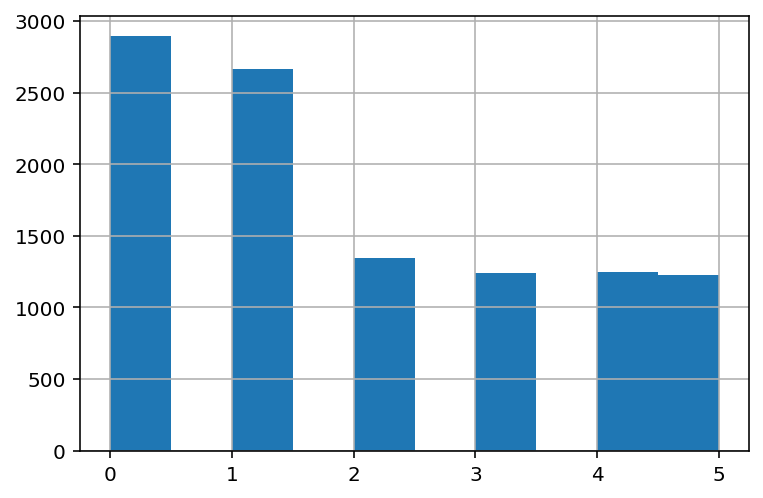

In [9]:
_ = TRAIN_DF[CFG.target_col].hist()

### Define Global Variables

In [10]:
if not CFG.resume:
    now = datetime.now()
    EXP_NAME = now.strftime("%d-%m-%Y-%H-%M")
    print(f"Start experiment: {EXP_NAME}")

    writer = SummaryWriter(f"runs_v1/{EXP_NAME}")
else:
    # if resume should define from what to start
    PREV_NAME = CFG.prev_exp
    writer = SummaryWriter(f"runs_v1/{PREV_NAME}_{CFG.stage}")

Start experiment: 10-06-2020-18-53


In [11]:
LOSSES = {
    "cce" : nn.CrossEntropyLoss(),
    "ls_soft_ce" : LabelSmoothSoftmaxCEV1(),
    "ohem" : TopkCrossEntropy(),
}

In [12]:
# key - string, value - tuple(sceduler, if it epoch type)
epoch_type = True
SCHEDULERS = {
    "reduce_on_plateau" : (ReduceLROnPlateau, epoch_type),
    "one_cycle": (OneCycleLR, not epoch_type),
    "cawr": (CosineAnnealingWarmRestarts, not epoch_type),
    "none": (None, None)
}

In [13]:
# schedulers
def get_scheduler(optimizer,train_dataloader, schedule_type=CFG.schedule_type, resume=False):
    assert schedule_type in SCHEDULERS, f"{schedule_type} not in SCHEDULERS"
    if schedule_type == "reduce_on_plateau":
        return (SCHEDULERS[schedule_type][0](optimizer, 'min', factor=0.5, patience=CFG.rlopp if not resume else CFG.rlopp + 2, verbose=True), 
                SCHEDULERS[schedule_type][1])
    elif schedule_type == "one_cycle":
        return (SCHEDULERS[schedule_type][0](optimizer, max_lr=[CFG.lr, CFG.lr*10] if CFG.finetune == "1stage" else CFG.lr,
                                             steps_per_epoch=int(len(train_dataloader) / CFG.accum_step), epochs=CFG.epoch, pct_start=1/CFG.epoch, cycle_momentum=False),
                SCHEDULERS[schedule_type][1])
    elif schedule_type == "cawr":
        return (SCHEDULERS[schedule_type][0](optimizer, T_0=len(train_dataloader)*CFG.cawr_T, T_mult=CFG.cawr_Tmult),
                SCHEDULERS[schedule_type][1])
    else:
        return (SCHEDULERS[schedule_type][0],
                SCHEDULERS[schedule_type][1])

### Train Eval Loop

In [14]:
# Train Eval Loop
def train_eval_loop(
    train_dataloader,
    val_dataloader,
    model,
    optimizer,
    criterion,
    accum_step=CFG.accum_step,
    checkpoint=False,
    num_epochs=CFG.epoch,
    device=device,
    tb_tag="",
    model_name="debug",
):
    """Split it into the set of inner functions to siplify the loop itself"""
    # Inner Functions
    # write to TensorBoard helpers
    def weights_to_tb(step=0):
        conv1_weight = list(model.parameters())[0].data.to("cpu")
        img_grid = torchvision.utils.make_grid(conv1_weight.float(), normalize=True)
        writer.add_image(
            tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=step
        )

    def input_img_to_tb(inputs, step):
        img = reverse_show_img(inputs[0], denorm=True)
        writer.add_image(
            tag=f"Input Image {tb_tag}",
            img_tensor=img,
            global_step=step,
            dataformats="HWC",
        )
        del img

    def preds_to_tb(outputs, inputs, labels, step):
        figure = plot_classes_preds(
            outputs.to("cpu"), inputs.to("cpu"), labels.to("cpu")
        )
        writer.add_figure(
            tag=f"Actuals vs Predictions {tb_tag}", figure=figure, global_step=step
        )

    def text_preds_to_tb(outputs, labels, step):
        preds_text = text_classes_preds(outputs.to("cpu"), labels.to("cpu"))
        writer.add_text(
            f"Actuals vs Predictions {tb_tag}", preds_text, global_step=step
        )

    def metrics_to_tb(mode, train_loss, train_score, val_loss, val_score, step):
        writer.add_text(
            f"On best {mode} save:",
            f"tr_loss: {train_loss:.4f}, tr_qwk: {train_score:.4f}, val_loss: {val_loss:.4f}, val_qwk: {val_score:.4f}",  # noqa
            global_step=step,
        )

    def conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, step):
        writer.add_figure(
            tag=f"Confusion matrix {tb_tag}",
            figure=plot_confusion_matrix(
                val_epoch_labels, val_epoch_preds, normalize=True
            ),
            global_step=step,
        )

    # Train/Eval Loop
    # write first layer weights to TB @ init phase
    if not CFG.debug:
        weights_to_tb()

    # prepare model and optimizer
    model.to(device)
    if CFG.use_amp:  # automatic mixed precision
        model, optimizer = amp.initialize(model, optimizer, opt_level="O2")
        
    # init scheduler after amp init of optimizer
    scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader, resume=CFG.resume)
    
    # define epochs numbers to look into input images and predictions,
    # no more than 10 times per full training
    vis_step = np.ceil(num_epochs / 10).astype(int)
    visual_epochs = list(range(0, num_epochs, vis_step))
    # metrics to wathch for model checkpointing
    best_qwk = -100 if not checkpoint else checkpoint["best_qwk"]
    best_val_loss = np.inf if not checkpoint else checkpoint["best_val_loss"]

    start_epoch = 0 if not checkpoint else checkpoint["epoch"] + 1
    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("=" * 10)

        # Training Phase
        # Set training mode
        model.train()
        train_running_loss = 0.0
        train_epoch_preds, train_epoch_labels = [], []

        # We accumulate, zero at training epoch begins
        optimizer.zero_grad()

        # Iterate over train data.
        tk_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, data in tk_train:
            # Calculate global step for TensorBoard
            train_global_step = epoch * len(train_dataloader) + i

            inputs, labels = data
            # Visualize input before model at the middle of epoch:
            if epoch in visual_epochs and i == len(train_dataloader) // 2:
                input_img_to_tb(inputs, train_global_step)

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if CFG.use_amp:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            # we accumulate gradients and make optimization step once per
            # # of accum_step
            if (i + 1) % accum_step == 0:
                optimizer.step()
                optimizer.zero_grad()
                # Add Batch Type Scheduler step here (update lr only after optimizer step):
                if scheduler and not sch_is_epoch_type:
                    scheduler.step()

            # loss is mean across batch, divide by number of steps in epoch
            # (so loss is normalized)
            train_running_loss += loss.item() / len(train_dataloader)
            # tensorboarding loss
            writer.add_scalar(
                tag=f"Training loss {tb_tag}",
                scalar_value=loss.item(),
                global_step=train_global_step,
            )

            # collect train preds and labels for QWK
            train_epoch_preds.append(outputs.data.to("cpu").numpy().argmax(1))
            train_epoch_labels.append(labels.to("cpu").numpy())
            
        # Validation Phase
        # Set evaluation mode
        model.eval()
        val_running_loss = 0.0
        val_epoch_preds, val_epoch_labels = [], []
        # Iterate over val data
        tk_val = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for j, data in tk_val:
            # Calculate global step
            val_global_step = epoch * len(val_dataloader) + j
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            if CFG.loss == "ohem":
                loss = criterion(outputs, labels, valid=True)
            else:
                loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() / len(val_dataloader)
            # tensorboarding loss
            writer.add_scalar(
                tag=f"Validation loss {tb_tag}",
                scalar_value=loss.item(),
                global_step=val_global_step,
            )

            # collect validation preds and labels for QWK
            val_epoch_preds.append(outputs.data.to("cpu").numpy().argmax(1))
            val_epoch_labels.append(labels.to("cpu").numpy())

            # visualise predictions for 0th validation batch
            if epoch in visual_epochs and j == 0:
                text_preds_to_tb(outputs, labels, val_global_step)

        # Epoch type Schedulers
        if scheduler and sch_is_epoch_type:
            scheduler.step(val_running_loss)
        # Write lr to TBD
        if CFG.finetune == "1stage":
            writer.add_scalar(
                tag=f"lr Interim {tb_tag}:",
                scalar_value=optimizer.param_groups[0]["lr"],
                global_step=train_global_step,
            )
            writer.add_scalar(
                tag=f"lr Classifier {tb_tag}:",
                scalar_value=optimizer.param_groups[1]["lr"],
                global_step=train_global_step,
            )

        else:
            writer.add_scalar(
                tag=f"lr {tb_tag}:",
                scalar_value=optimizer.param_groups[0]["lr"],
                global_step=train_global_step,
            )

        # "End of Epoch" Phase
        print(
            f"Training Loss: {train_running_loss:.4f}\tValidation Loss: {val_running_loss:.4f}"  # noqa
        )

        # Calculate epoch predictions distribution
        train_epoch_preds = np.concatenate(train_epoch_preds)
        train_epoch_labels = np.concatenate(train_epoch_labels)
        val_epoch_preds = np.concatenate(val_epoch_preds)
        val_epoch_labels = np.concatenate(val_epoch_labels)
        print(
            f"Counter train preds: {Counter(train_epoch_preds)}\tCounter val preds: {Counter(val_epoch_preds)}"  # noqa
        )
        # Calculate epoch QWK
        train_qwk = cohen_kappa_score(
            train_epoch_preds, train_epoch_labels, weights="quadratic"
        )
        val_qwk = cohen_kappa_score(
            val_epoch_preds, val_epoch_labels, weights="quadratic"
        )
        print(f"Epoch train QWK: {train_qwk:.3f}\tval QWK: {val_qwk:.3f}")
        writer.add_scalar(
            tag=f"Training QWK {tb_tag}", scalar_value=train_qwk, global_step=epoch
        )
        writer.add_scalar(
            tag=f"Validation QWK {tb_tag}", scalar_value=val_qwk, global_step=epoch
        )

        # On the best val loss do:
        if val_running_loss < best_val_loss:
            # update best and save model
            best_val_loss = val_running_loss
            best_qwk = val_qwk
            print(f"  Epoch {epoch} - Save Best Loss: {best_val_loss:.4f} Model")
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "best_val_loss": best_val_loss,
                    "best_qwk": best_qwk,
                },
                f"{MODEL_PATH}/{model_name}_{epoch}_loss.pth",
            )
            # add losses as text to TB
            metrics_to_tb(
                "loss",
                train_running_loss,
                train_qwk,
                val_running_loss,
                val_qwk,
                val_global_step,
            )
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)

    # End of loop
    return model, best_val_loss, best_qwk

### Prepare CV - strategy

In [15]:
# That for the first time

In [13]:
if CFG.debug:
    folds_fn = "folds_db.csv"
    try: 
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.sample(n=100, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds_fn = "folds.csv"
    try:
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.copy()

In [14]:
if not (PANDA_PATH/folds_fn).exists():
    train_labels = folds[CFG.target_col].values
    kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
        folds.loc[val_index, 'fold'] = int(fold)
    folds['fold'] = folds['fold'].astype(int)
    folds.to_csv(PANDA_PATH/folds_fn, index=None)
    folds.head()

In [2]:
# Here use existing (folds_dedup is folds_cleaned + dropped duplicates)
# See corresponding notebooks: Suspicious_Input for cleaning
# and Find_Drop_Duplicates for duplicates

In [15]:
if CFG.debug:
    folds = pd.read_csv(PANDA_PATH/"folds_db.csv")
else:
    folds = pd.read_csv(PANDA_PATH/"folds_dedup.csv")

In [16]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       100 non-null    object
 1   data_provider  100 non-null    object
 2   isup_grade     100 non-null    int64 
 3   gleason_score  100 non-null    object
 4   fold           100 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 4.0+ KB


### Init Data

In [17]:
# get folds (all experiments validated on fold 0)
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()

# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False) # same allways to compare with previous results
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = PatchTrainDataset(val_df, is_train=False, debug=False)
elif CFG.dataset == "hdf5":
    train_ds = H5PatchDataset(file_path=PANDA_PATH / "hdf5", fnames=["patch256x16x1_fold_1.h5", "patch256x16x1_fold_2.h5", "patch256x16x1_fold_3.h5"])
    val_ds = H5PatchDataset(file_path=PANDA_PATH / "hdf5", fnames=["patch256x16x1_fold_0.h5"])
else:
    print(f"No such dataset {CFG.dataset}")
    
# define a data loader
if CFG.dataset == "hdf5":
    # use specific sampler (so not to load hdf5 files to memory too frequently)
    sampler = SeqenceRandomSampler(len(train_ds), train_ds._common_len)
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, sampler=sampler, num_workers=min(CFG.batch_size, 8), pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size, 8), pin_memory=True)
else:
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size+2, 8), pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size+2, 8), pin_memory=True)

### Init Functions

In [18]:
def init_model(train_df=train_df, arch=CFG.arch):
    # separate Patch Model class for EfficientNet
    # no bias init as in the 0.87 kernel so use model as in kernel
    # and everything else as in my pipeline
    if arch == "efnet":
        model_ft = PatchEnetModel()
    else:
        model_ft = PatchModel(arch=CFG.arch)
        # initialize bias in the model
        cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
        model_ft = init_last_layer_bias(model_ft, cls_probas)
    return model_ft


def init_optimizer(model_ft):
    if CFG.finetune == "1stage":
        freeze_botom(model_ft)
        interm_params = [
            p[1]
            for p in model_ft.named_parameters()
            if (not p[0].startswith("fc") and p[1].requires_grad)
        ]
        if CFG.optim == "adam":
            optimizer = torch.optim.Adam(
                [
                    {"params": interm_params, "lr": CFG.lr},
                    {"params": model_ft.fc.parameters(), "lr": CFG.lr * 10},
                ]
            )
        elif CFG.optim == "sgd":
            optimizer = torch.optim.SGD(
                [
                    {"params": interm_params, "lr": CFG.lr},
                    {"params": model_ft.fc.parameters(), "lr": CFG.lr * 10},
                ],
                momentum=0.9,
                nesterov=True,
            )
    else:
        if CFG.optim == "adam":
            optimizer = torch.optim.Adam(
                model_ft.parameters(), lr=CFG.lr, amsgrad=False
            )
        elif CFG.optim == "sgd":
            optimizer = torch.optim.SGD(
                model_ft.parameters(), lr=CFG.lr, momentum=0.9, nesterov=True
            )
        elif CFG.optim == "radam":
            optimizer = RAdam(model_ft.parameters(), lr=CFG.lr)

    return optimizer

criterion = LOSSES[CFG.loss]

### Debug Runs

In [19]:
print(" ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: True seed: 1982 img_height: 256 img_width: 256 target_size: 6 img_id_col: image_id target_col: isup_grade tiff_layer: 1 stoch_sample: True num_tiles: 32 tile_sz: 256 batch_size: 3 accum_step: 4 dataset: patch aug_type: light arch: efnet finetune: False model_cls: one_layer loss: ohem optim: radam lr: 0.0003 schedule_type: one_cycle cawr_T: 1 cawr_Tmult: 2 rlopp: 1 resume: False prev_exp: None from_epoch: 0 stage: 0 epoch: 40 n_fold: 4 use_amp: True descript: OHEM + rn34 + one cycle + 256x16 + aug


In [20]:
model_ft = init_model()
optimizer = init_optimizer(model_ft)
    
scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader)

_ = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, num_epochs=3)

Loaded pretrained weights for efficientnet-b0
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Epoch 0/2


 12%|█▏        | 3/25 [00:02<00:22,  1.01s/it]/home/ademyanchuk/.cache/pypoetry/virtualenvs/chestxray-uNc73CMC-py3.7/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
 16%|█▌        | 4/25 [00:02<00:17,  1.23it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


 32%|███▏      | 8/25 [00:04<00:07,  2.19it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


 48%|████▊     | 12/25 [00:05<00:04,  2.69it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0


 60%|██████    | 15/25 [00:06<00:03,  2.71it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)
100%|██████████| 9/9 [00:01<00:00,  4.83it/s]


Training Loss: 33.3803	Validation Loss: 30.9604
Counter train preds: Counter({0: 24, 1: 18, 2: 16, 3: 9, 4: 5, 5: 3})	Counter val preds: Counter({4: 25})
Epoch train QWK: 0.062	val QWK: 0.000
  Epoch 0 - Save Best Loss: 30.9604 Model
Normalized confusion matrix
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]
Epoch 1/2


 48%|████▊     | 12/25 [00:05<00:04,  2.74it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0


100%|██████████| 9/9 [00:01<00:00,  4.77it/s]


Training Loss: 58.4407	Validation Loss: 22.2881
Counter train preds: Counter({1: 56, 4: 12, 3: 7})	Counter val preds: Counter({1: 24, 3: 1})
Epoch train QWK: 0.031	val QWK: 0.059
  Epoch 1 - Save Best Loss: 22.2881 Model
Normalized confusion matrix
[[0.         1.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.66666667 0.         0.33333333 0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]]
Epoch 2/2


100%|██████████| 9/9 [00:02<00:00,  4.44it/s]

Training Loss: 53.4790	Validation Loss: 23.1088
Counter train preds: Counter({1: 68, 3: 7})	Counter val preds: Counter({1: 23, 3: 2})
Epoch train QWK: -0.056	val QWK: -0.029


### Experiment Run

#### Learning Rate Finder

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic



Learning rate search finished. See the graph with {finder_name}.plot()


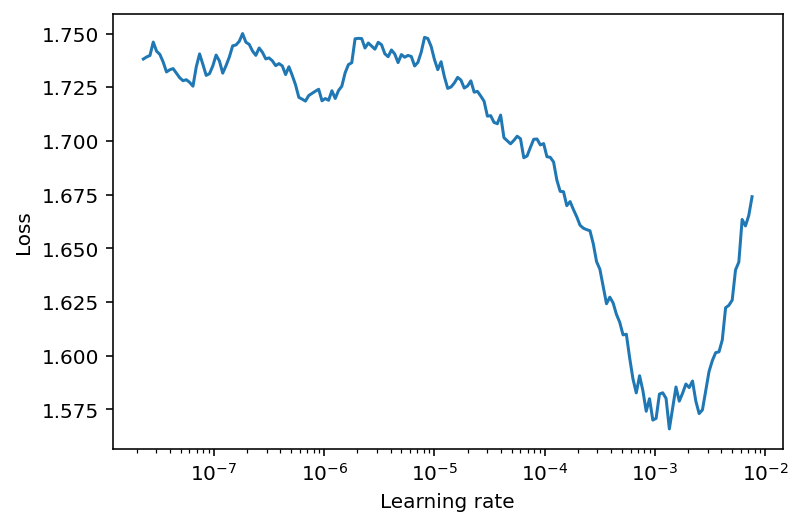

In [17]:
# get folds
train_df = folds[folds["fold"] != 0].copy()
# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    
# define a data loader
train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size, 10), pin_memory=True)

model_ft = Model(arch="resnet34")
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)
model_ft.to(device)

criterion = LOSSES[CFG.loss]


if CFG.finetune == "1stage":
    freeze_botom(model_ft)
    interm_params = [p[1] for p in model_ft.named_parameters() if (not p[0].startswith('fc') and p[1].requires_grad)]
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
                ])
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
            ], momentum=0.9, nesterov=True)
else:
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr * 1e-4, amsgrad=False)
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD(model_ft.parameters(), lr=CFG.lr * 1e-4, momentum=0.9, nesterov=True)
    elif CFG.optim == "radam":
        optimizer = RAdam(model_ft.parameters(), lr=CFG.lr * 1e-4)
    
if CFG.use_amp:
    model_ft, optimizer = amp.initialize(model_ft, optimizer, opt_level='O1')
    
lr_finder = LRFinder(model_ft, optimizer, criterion, device=device)
lr_finder.range_test(train_dataloader, end_lr=1e-2, num_iter=200, step_mode="exp", accumulation_steps=CFG.accum_step)
lr_finder.plot()
lr_finder.reset()

#### Experiment

In [19]:
print(" ".join([f"{key}: {val}\n" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: False
 seed: 1982
 img_height: 256
 img_width: 256
 target_size: 6
 img_id_col: image_id
 target_col: isup_grade
 tiff_layer: 1
 stoch_sample: True
 num_tiles: 32
 tile_sz: 256
 batch_size: 4
 accum_step: 2
 dataset: patch
 aug_type: heavy
 arch: resnet34
 finetune: False
 model_cls: one_layer
 loss: ohem
 optim: radam
 lr: 0.0003
 schedule_type: one_cycle
 cawr_T: 1
 cawr_Tmult: 2
 rlopp: 1
 resume: False
 prev_exp: None
 from_epoch: 0
 stage: 0
 epoch: 40
 n_fold: 4
 use_amp: True
 descript: OHEM + rn34 + one cycle + 256x16 + aug



In [20]:
writer.add_text("Experiment Description:", CFG.descript)

In [21]:
model_ft = init_model()
optimizer = init_optimizer(model_ft)


In [22]:
# Start Train/Eval Experiment
model_ft, best_loss, best_qwk = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, model_name=EXP_NAME)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Epoch 0/39


  0%|          | 1/1885 [00:01<1:01:25,  1.96s/it]/home/ademyanchuk/.cache/pypoetry/virtualenvs/chestxray-uNc73CMC-py3.7/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 2/1885 [00:02<46:38,  1.49s/it]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


  0%|          | 4/1885 [00:02<27:52,  1.12it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


  0%|          | 6/1885 [00:03<18:21,  1.71it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


  0%|          | 7/1885 [00:03<16:37,  1.88it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)
100%|██████████| 631/631 [02:27<00:00,  4.29it/s]


Training Loss: 2.4628	Validation Loss: 1.5035
Counter train preds: Counter({0: 2128, 1: 2060, 4: 972, 2: 872, 3: 804, 5: 704})	Counter val preds: Counter({1: 1578, 0: 565, 3: 155, 4: 109, 5: 94, 2: 20})
Epoch train QWK: 0.292	val QWK: 0.436
  Epoch 0 - Save Best Loss: 1.5035 Model
Normalized confusion matrix
[[0.55898876 0.41011236 0.         0.00561798 0.01825843 0.00702247]
 [0.0862069  0.89811912 0.0031348  0.00470219 0.00783699 0.        ]
 [0.07301587 0.86031746 0.00634921 0.04444444 0.00952381 0.00634921]
 [0.07586207 0.7        0.01724138 0.13793103 0.02758621 0.04137931]
 [0.12371134 0.49484536 0.01030928 0.15120275 0.13058419 0.08934708]
 [0.11272727 0.34545455 0.02909091 0.18181818 0.15272727 0.17818182]]
Epoch 1/39


  7%|▋         | 126/1885 [00:39<08:43,  3.36it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


100%|██████████| 631/631 [02:28<00:00,  4.24it/s]


Training Loss: 2.1750	Validation Loss: 1.2799
Counter train preds: Counter({0: 2151, 1: 2013, 2: 907, 4: 892, 3: 808, 5: 769})	Counter val preds: Counter({1: 1499, 0: 407, 4: 220, 2: 186, 5: 135, 3: 74})
Epoch train QWK: 0.497	val QWK: 0.591
  Epoch 1 - Save Best Loss: 1.2799 Model
Normalized confusion matrix
[[0.48033708 0.48174157 0.00140449 0.00702247 0.0252809  0.00421348]
 [0.05329154 0.89968652 0.03918495 0.0031348  0.00470219 0.        ]
 [0.02857143 0.74920635 0.19365079 0.01587302 0.01269841 0.        ]
 [0.03448276 0.53103448 0.18965517 0.04827586 0.14827586 0.04827586]
 [0.00687285 0.395189   0.08247423 0.08591065 0.32302405 0.10652921]
 [0.03636364 0.28       0.07272727 0.08363636 0.21090909 0.31636364]]
Epoch 2/39


 80%|████████  | 1510/1885 [07:39<01:52,  3.35it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


100%|██████████| 631/631 [02:28<00:00,  4.26it/s]


Training Loss: 1.8775	Validation Loss: 1.1833
Counter train preds: Counter({0: 2265, 1: 2090, 2: 865, 4: 840, 5: 760, 3: 720})	Counter val preds: Counter({0: 1174, 3: 537, 1: 334, 5: 237, 2: 178, 4: 61})
Epoch train QWK: 0.602	val QWK: 0.662
  Epoch 2 - Save Best Loss: 1.1833 Model
Normalized confusion matrix
[[0.97331461 0.00280899 0.00421348 0.00140449 0.         0.01825843]
 [0.37617555 0.40282132 0.13009404 0.0846395  0.         0.00626959]
 [0.22857143 0.16825397 0.20634921 0.38095238 0.         0.01587302]
 [0.2        0.04482759 0.05517241 0.56206897 0.02758621 0.11034483]
 [0.20962199 0.02749141 0.03092784 0.41237113 0.11683849 0.20274914]
 [0.18181818 0.00363636 0.00727273 0.28727273 0.06909091 0.45090909]]
Epoch 3/39


100%|██████████| 631/631 [02:34<00:00,  4.10it/s]

Training Loss: 1.7142	Validation Loss: 1.3577
Counter train preds: Counter({0: 2334, 1: 2024, 2: 869, 3: 796, 4: 773, 5: 744})	Counter val preds: Counter({1: 1471, 0: 460, 3: 342, 4: 178, 2: 70})
Epoch train QWK: 0.672	val QWK: 0.552
Epoch 4/39



 93%|█████████▎| 1746/1885 [09:23<00:42,  3.28it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 631/631 [02:36<00:00,  4.04it/s]


Training Loss: 1.6155	Validation Loss: 1.0654
Counter train preds: Counter({0: 2374, 1: 1997, 2: 882, 4: 799, 3: 756, 5: 732})	Counter val preds: Counter({1: 798, 0: 744, 4: 320, 5: 246, 3: 240, 2: 173})
Epoch train QWK: 0.694	val QWK: 0.755
  Epoch 4 - Save Best Loss: 1.0654 Model
Normalized confusion matrix
[[0.82022472 0.14325843 0.00280899 0.00421348 0.00842697 0.02106742]
 [0.10501567 0.78840125 0.06583072 0.02194357 0.01253918 0.00626959]
 [0.04444444 0.41269841 0.30793651 0.19047619 0.03809524 0.00634921]
 [0.08965517 0.13103448 0.05862069 0.33103448 0.21034483 0.17931034]
 [0.09278351 0.06185567 0.03780069 0.13058419 0.52233677 0.15463918]
 [0.09454545 0.02545455 0.01454545 0.10545455 0.29454545 0.46545455]]
Epoch 5/39


 32%|███▏      | 594/1885 [03:05<06:29,  3.31it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


100%|██████████| 631/631 [02:29<00:00,  4.23it/s]

Training Loss: 1.5918	Validation Loss: 1.1626
Counter train preds: Counter({0: 2398, 1: 2048, 4: 849, 2: 819, 3: 731, 5: 695})	Counter val preds: Counter({5: 737, 0: 715, 1: 564, 2: 306, 3: 179, 4: 20})
Epoch train QWK: 0.704	val QWK: 0.717
Epoch 6/39



100%|██████████| 631/631 [02:29<00:00,  4.23it/s]

Training Loss: 1.5844	Validation Loss: 1.1916
Counter train preds: Counter({0: 2356, 1: 2069, 2: 852, 4: 775, 3: 761, 5: 727})	Counter val preds: Counter({1: 1019, 4: 532, 0: 348, 5: 284, 2: 275, 3: 63})
Epoch train QWK: 0.702	val QWK: 0.752
Epoch 7/39



 46%|████▌     | 864/1885 [04:22<05:06,  3.33it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 631/631 [02:29<00:00,  4.22it/s]

Training Loss: 1.5396	Validation Loss: 1.2285
Counter train preds: Counter({0: 2382, 1: 2034, 4: 802, 2: 799, 3: 766, 5: 757})	Counter val preds: Counter({1: 764, 0: 697, 5: 513, 4: 468, 3: 79})
Epoch train QWK: 0.726	val QWK: 0.690
Epoch 8/39



 53%|█████▎    | 998/1885 [05:02<04:22,  3.39it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 631/631 [02:29<00:00,  4.23it/s]

Training Loss: 1.4983	Validation Loss: 1.0867
Counter train preds: Counter({0: 2441, 1: 1982, 2: 864, 4: 771, 5: 761, 3: 721})	Counter val preds: Counter({1: 1055, 0: 845, 3: 300, 4: 265, 2: 31, 5: 25})
Epoch train QWK: 0.744	val QWK: 0.670
Epoch 9/39



 29%|██▉       | 550/1885 [02:47<06:34,  3.38it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


100%|██████████| 631/631 [02:29<00:00,  4.22it/s]

Training Loss: 1.4902	Validation Loss: 1.0803
Counter train preds: Counter({0: 2395, 1: 1979, 2: 861, 3: 799, 4: 770, 5: 736})	Counter val preds: Counter({1: 938, 0: 713, 5: 477, 4: 247, 3: 82, 2: 64})
Epoch train QWK: 0.750	val QWK: 0.768
Epoch 10/39



 53%|█████▎    | 994/1885 [05:01<04:27,  3.34it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


100%|██████████| 631/631 [02:29<00:00,  4.22it/s]


Training Loss: 1.4357	Validation Loss: 1.0239
Counter train preds: Counter({0: 2432, 1: 1986, 2: 852, 4: 784, 3: 760, 5: 726})	Counter val preds: Counter({0: 827, 1: 673, 3: 365, 2: 288, 4: 261, 5: 107})
Epoch train QWK: 0.771	val QWK: 0.771
  Epoch 10 - Save Best Loss: 1.0239 Model
Normalized confusion matrix
[[0.92275281 0.06882022 0.00140449 0.         0.00561798 0.00140449]
 [0.11912226 0.71003135 0.14733542 0.02037618 0.0031348  0.        ]
 [0.03174603 0.38412698 0.4031746  0.15873016 0.02222222 0.        ]
 [0.10344828 0.08965517 0.14137931 0.53448276 0.09655172 0.03448276]
 [0.09278351 0.05841924 0.05498282 0.27147766 0.46391753 0.05841924]
 [0.09818182 0.02545455 0.03272727 0.24727273 0.30909091 0.28727273]]
Epoch 11/39


 62%|██████▏   | 1162/1885 [05:52<03:35,  3.35it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


100%|██████████| 631/631 [02:29<00:00,  4.22it/s]

Training Loss: 1.4153	Validation Loss: 1.0430
Counter train preds: Counter({0: 2423, 1: 2011, 2: 815, 3: 794, 4: 750, 5: 747})	Counter val preds: Counter({1: 873, 0: 855, 3: 289, 5: 198, 2: 187, 4: 119})
Epoch train QWK: 0.772	val QWK: 0.725
Epoch 12/39



 91%|█████████ | 1714/1885 [08:40<00:50,  3.36it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


100%|██████████| 631/631 [02:29<00:00,  4.22it/s]


Training Loss: 1.4155	Validation Loss: 0.9794
Counter train preds: Counter({0: 2395, 1: 1979, 2: 844, 3: 803, 4: 776, 5: 743})	Counter val preds: Counter({0: 829, 1: 744, 5: 438, 2: 290, 3: 129, 4: 91})
Epoch train QWK: 0.771	val QWK: 0.780
  Epoch 12 - Save Best Loss: 0.9794 Model
Normalized confusion matrix
[[0.90589888 0.08567416 0.00140449 0.         0.         0.00702247]
 [0.10501567 0.80564263 0.07210031 0.00783699 0.0015674  0.00783699]
 [0.06031746 0.39365079 0.47619048 0.03174603 0.0031746  0.03492063]
 [0.1137931  0.08275862 0.20689655 0.24827586 0.04827586 0.3       ]
 [0.12027491 0.05154639 0.08247423 0.11683849 0.22680412 0.40206186]
 [0.10909091 0.02181818 0.03272727 0.02909091 0.03272727 0.77454545]]
Epoch 13/39


100%|██████████| 631/631 [02:29<00:00,  4.23it/s]

Training Loss: 1.3772	Validation Loss: 1.0290
Counter train preds: Counter({0: 2390, 1: 2028, 2: 844, 3: 772, 4: 770, 5: 736})	Counter val preds: Counter({1: 674, 0: 666, 3: 503, 2: 383, 5: 178, 4: 117})
Epoch train QWK: 0.789	val QWK: 0.782
Epoch 14/39



 84%|████████▍ | 1582/1885 [07:59<01:30,  3.35it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


100%|██████████| 631/631 [02:28<00:00,  4.24it/s]

Training Loss: 1.3453	Validation Loss: 1.0178
Counter train preds: Counter({0: 2422, 1: 1997, 2: 854, 4: 794, 5: 751, 3: 722})	Counter val preds: Counter({1: 707, 0: 659, 2: 430, 5: 412, 4: 239, 3: 74})
Epoch train QWK: 0.795	val QWK: 0.803
Epoch 15/39



100%|██████████| 631/631 [02:29<00:00,  4.22it/s]


Training Loss: 1.3194	Validation Loss: 0.9320
Counter train preds: Counter({0: 2387, 1: 2006, 2: 831, 3: 793, 4: 776, 5: 747})	Counter val preds: Counter({0: 914, 1: 595, 3: 317, 2: 268, 5: 245, 4: 182})
Epoch train QWK: 0.806	val QWK: 0.792
  Epoch 15 - Save Best Loss: 0.9320 Model
Normalized confusion matrix
[[0.9761236  0.02106742 0.00140449 0.         0.         0.00140449]
 [0.15517241 0.70532915 0.10501567 0.02978056 0.0031348  0.0015674 ]
 [0.06666667 0.32698413 0.39365079 0.18730159 0.01587302 0.00952381]
 [0.12068966 0.05172414 0.15517241 0.49310345 0.07241379 0.10689655]
 [0.13058419 0.03780069 0.06872852 0.19931271 0.3814433  0.18213058]
 [0.09454545 0.00363636 0.04       0.13818182 0.15636364 0.56727273]]
Epoch 16/39


 99%|█████████▉| 1874/1885 [09:28<00:03,  3.33it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 631/631 [02:29<00:00,  4.22it/s]

Training Loss: 1.3044	Validation Loss: 0.9718
Counter train preds: Counter({0: 2401, 1: 1991, 2: 823, 4: 811, 3: 784, 5: 730})	Counter val preds: Counter({0: 814, 1: 502, 3: 443, 4: 347, 2: 347, 5: 68})
Epoch train QWK: 0.810	val QWK: 0.791
Epoch 17/39



100%|██████████| 631/631 [02:29<00:00,  4.22it/s]

Training Loss: 1.2698	Validation Loss: 0.9588
Counter train preds: Counter({0: 2377, 1: 2012, 2: 802, 3: 799, 4: 792, 5: 758})	Counter val preds: Counter({0: 801, 1: 510, 2: 421, 3: 409, 4: 301, 5: 79})
Epoch train QWK: 0.826	val QWK: 0.792
Epoch 18/39



  7%|▋         | 128/1885 [00:40<08:41,  3.37it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


 34%|███▍      | 650/1885 [03:18<06:04,  3.39it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


100%|██████████| 631/631 [02:30<00:00,  4.20it/s]


Training Loss: 1.2533	Validation Loss: 0.9238
Counter train preds: Counter({0: 2390, 1: 1982, 2: 857, 4: 789, 3: 773, 5: 749})	Counter val preds: Counter({0: 842, 1: 620, 4: 518, 5: 185, 3: 179, 2: 177})
Epoch train QWK: 0.823	val QWK: 0.823
  Epoch 18 - Save Best Loss: 0.9238 Model
Normalized confusion matrix
[[0.95365169 0.03089888 0.         0.00140449 0.01123596 0.00280899]
 [0.13479624 0.73040752 0.09247649 0.01567398 0.02507837 0.0015674 ]
 [0.02857143 0.33333333 0.31746032 0.15555556 0.15555556 0.00952381]
 [0.09655172 0.06551724 0.03793103 0.29310345 0.4        0.10689655]
 [0.06872852 0.02405498 0.02405498 0.07216495 0.73195876 0.0790378 ]
 [0.07272727 0.00363636 0.         0.04727273 0.42181818 0.45454545]]
Epoch 19/39


100%|██████████| 631/631 [02:28<00:00,  4.25it/s]


Training Loss: 1.2152	Validation Loss: 0.8808
Counter train preds: Counter({0: 2375, 1: 2000, 2: 824, 3: 789, 5: 782, 4: 770})	Counter val preds: Counter({0: 811, 1: 675, 4: 472, 2: 209, 5: 185, 3: 169})
Epoch train QWK: 0.834	val QWK: 0.823
  Epoch 19 - Save Best Loss: 0.8808 Model
Normalized confusion matrix
[[0.93820225 0.04073034 0.00561798 0.00140449 0.00842697 0.00561798]
 [0.10658307 0.77899687 0.0799373  0.01253918 0.02037618 0.0015674 ]
 [0.03174603 0.37460317 0.35555556 0.13015873 0.1047619  0.0031746 ]
 [0.09310345 0.05862069 0.09310345 0.3137931  0.36551724 0.07586207]
 [0.05498282 0.03092784 0.04123711 0.06185567 0.71477663 0.09621993]
 [0.08       0.01818182 0.01090909 0.03636364 0.38545455 0.46909091]]
Epoch 20/39


 47%|████▋     | 886/1885 [04:29<04:57,  3.36it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 631/631 [02:28<00:00,  4.24it/s]

Training Loss: 1.1977	Validation Loss: 0.9372
Counter train preds: Counter({0: 2359, 1: 1974, 2: 845, 3: 794, 5: 787, 4: 781})	Counter val preds: Counter({0: 691, 1: 616, 2: 528, 4: 476, 5: 162, 3: 48})
Epoch train QWK: 0.833	val QWK: 0.818
Epoch 21/39



 54%|█████▍    | 1014/1885 [05:08<04:17,  3.38it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 631/631 [02:29<00:00,  4.22it/s]

Training Loss: 1.1641	Validation Loss: 0.8991
Counter train preds: Counter({0: 2357, 1: 1953, 2: 877, 4: 797, 3: 785, 5: 771})	Counter val preds: Counter({1: 767, 0: 684, 2: 334, 3: 311, 5: 261, 4: 164})
Epoch train QWK: 0.850	val QWK: 0.814
Epoch 22/39



 60%|██████    | 1132/1885 [05:43<03:43,  3.37it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 631/631 [02:29<00:00,  4.22it/s]


Training Loss: 1.1269	Validation Loss: 0.8519
Counter train preds: Counter({0: 2347, 1: 1987, 2: 835, 3: 793, 4: 790, 5: 788})	Counter val preds: Counter({0: 820, 1: 639, 2: 357, 4: 323, 3: 240, 5: 142})
Epoch train QWK: 0.856	val QWK: 0.810
  Epoch 22 - Save Best Loss: 0.8519 Model
Normalized confusion matrix
[[0.94241573 0.04494382 0.00421348 0.         0.00561798 0.00280899]
 [0.09874608 0.76332288 0.11912226 0.01253918 0.00626959 0.        ]
 [0.03809524 0.2984127  0.54603175 0.08253968 0.03174603 0.0031746 ]
 [0.08965517 0.05517241 0.24137931 0.43103448 0.14482759 0.03793103]
 [0.07560137 0.02749141 0.09278351 0.14776632 0.59450172 0.06185567]
 [0.09454545 0.00727273 0.03272727 0.13818182 0.32727273 0.4       ]]
Epoch 23/39


 38%|███▊      | 708/1885 [03:36<05:46,  3.39it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


 64%|██████▎   | 1198/1885 [06:04<03:21,  3.40it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0


100%|██████████| 631/631 [02:30<00:00,  4.20it/s]

Training Loss: 1.1084	Validation Loss: 0.9232
Counter train preds: Counter({0: 2333, 1: 1972, 2: 854, 4: 800, 3: 799, 5: 782})	Counter val preds: Counter({0: 688, 1: 597, 2: 421, 4: 389, 5: 223, 3: 203})
Epoch train QWK: 0.862	val QWK: 0.832
Epoch 24/39



100%|██████████| 631/631 [02:29<00:00,  4.23it/s]

Training Loss: 1.0709	Validation Loss: 0.8878
Counter train preds: Counter({0: 2323, 1: 1973, 2: 855, 3: 814, 4: 799, 5: 776})	Counter val preds: Counter({1: 830, 0: 675, 4: 279, 3: 266, 5: 238, 2: 233})
Epoch train QWK: 0.876	val QWK: 0.823
Epoch 25/39



100%|██████████| 631/631 [02:29<00:00,  4.22it/s]


Training Loss: 1.0328	Validation Loss: 0.8305
Counter train preds: Counter({0: 2310, 1: 1955, 2: 879, 4: 837, 3: 795, 5: 764})	Counter val preds: Counter({0: 760, 1: 663, 2: 353, 5: 292, 4: 250, 3: 203})
Epoch train QWK: 0.884	val QWK: 0.825
  Epoch 25 - Save Best Loss: 0.8305 Model
Normalized confusion matrix
[[0.89325843 0.08426966 0.00421348 0.         0.00842697 0.00983146]
 [0.0815047  0.76018809 0.14106583 0.01097179 0.00470219 0.0015674 ]
 [0.02222222 0.2952381  0.55555556 0.08888889 0.03174603 0.00634921]
 [0.08275862 0.05172414 0.19655172 0.37931034 0.16206897 0.12758621]
 [0.08247423 0.02405498 0.0790378  0.12027491 0.48109966 0.21305842]
 [0.06181818 0.01090909 0.01818182 0.08363636 0.16       0.66545455]]
Epoch 26/39


 83%|████████▎ | 1564/1885 [07:53<01:36,  3.34it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 631/631 [02:29<00:00,  4.22it/s]


Training Loss: 1.0161	Validation Loss: 0.8281
Counter train preds: Counter({0: 2300, 1: 1954, 2: 855, 4: 822, 3: 814, 5: 795})	Counter val preds: Counter({0: 765, 1: 686, 4: 367, 2: 251, 3: 250, 5: 202})
Epoch train QWK: 0.894	val QWK: 0.836
  Epoch 26 - Save Best Loss: 0.8281 Model
Normalized confusion matrix
[[0.90730337 0.08146067 0.00280899 0.         0.00842697 0.        ]
 [0.07836991 0.79310345 0.10188088 0.01724138 0.00783699 0.0015674 ]
 [0.02222222 0.31111111 0.42857143 0.14920635 0.07936508 0.00952381]
 [0.08275862 0.05172414 0.1        0.44827586 0.24482759 0.07241379]
 [0.05841924 0.02405498 0.05498282 0.13058419 0.62542955 0.10652921]
 [0.07636364 0.00727273 0.01454545 0.08727273 0.28363636 0.53090909]]
Epoch 27/39


 89%|████████▉ | 1682/1885 [08:30<01:00,  3.36it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 631/631 [02:29<00:00,  4.22it/s]


Training Loss: 0.9730	Validation Loss: 0.8191
Counter train preds: Counter({0: 2310, 1: 1959, 2: 860, 5: 818, 3: 798, 4: 795})	Counter val preds: Counter({0: 810, 1: 649, 4: 334, 2: 255, 5: 246, 3: 227})
Epoch train QWK: 0.895	val QWK: 0.833
  Epoch 27 - Save Best Loss: 0.8191 Model
Normalized confusion matrix
[[0.94662921 0.04494382 0.00140449 0.         0.00561798 0.00140449]
 [0.09404389 0.76959248 0.10815047 0.01410658 0.00783699 0.00626959]
 [0.02857143 0.32380952 0.42857143 0.13650794 0.06349206 0.01904762]
 [0.0862069  0.04482759 0.1137931  0.42413793 0.23103448 0.1       ]
 [0.07216495 0.03436426 0.04810997 0.10996564 0.58075601 0.15463918]
 [0.07636364 0.00363636 0.01090909 0.07272727 0.25090909 0.58545455]]
Epoch 28/39


 97%|█████████▋| 1824/1885 [09:13<00:17,  3.40it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 631/631 [02:29<00:00,  4.23it/s]

Training Loss: 0.9204	Validation Loss: 0.8421
Counter train preds: Counter({0: 2265, 1: 1980, 3: 863, 2: 853, 5: 806, 4: 773})	Counter val preds: Counter({0: 781, 1: 504, 2: 436, 4: 364, 5: 226, 3: 210})
Epoch train QWK: 0.909	val QWK: 0.826
Epoch 29/39



100%|██████████| 631/631 [02:27<00:00,  4.27it/s]

Training Loss: 0.9070	Validation Loss: 0.8392
Counter train preds: Counter({0: 2287, 1: 1930, 2: 886, 3: 848, 5: 803, 4: 786})	Counter val preds: Counter({0: 721, 1: 697, 2: 306, 5: 294, 3: 262, 4: 241})
Epoch train QWK: 0.911	val QWK: 0.827
Epoch 30/39



  5%|▍         | 86/1885 [00:27<09:02,  3.32it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 631/631 [02:29<00:00,  4.23it/s]

Training Loss: 0.8611	Validation Loss: 0.8260
Counter train preds: Counter({0: 2262, 1: 1968, 2: 854, 4: 832, 3: 824, 5: 800})	Counter val preds: Counter({0: 722, 1: 692, 4: 311, 2: 290, 3: 276, 5: 230})
Epoch train QWK: 0.916	val QWK: 0.839
Epoch 31/39



 12%|█▏        | 228/1885 [01:11<08:21,  3.30it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 631/631 [02:28<00:00,  4.24it/s]

Training Loss: 0.8303	Validation Loss: 0.8227
Counter train preds: Counter({0: 2268, 1: 1949, 2: 880, 5: 819, 4: 815, 3: 809})	Counter val preds: Counter({0: 767, 1: 567, 2: 388, 5: 298, 4: 273, 3: 228})
Epoch train QWK: 0.927	val QWK: 0.829
Epoch 32/39



 18%|█▊        | 348/1885 [01:47<07:48,  3.28it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 631/631 [02:28<00:00,  4.24it/s]


Training Loss: 0.7944	Validation Loss: 0.8148
Counter train preds: Counter({0: 2252, 1: 1946, 2: 884, 3: 835, 5: 835, 4: 788})	Counter val preds: Counter({0: 775, 1: 698, 4: 309, 3: 291, 2: 225, 5: 223})
Epoch train QWK: 0.924	val QWK: 0.835
  Epoch 32 - Save Best Loss: 0.8148 Model
Normalized confusion matrix
[[0.9241573  0.06039326 0.00280899 0.00140449 0.00421348 0.00702247]
 [0.07836991 0.81661442 0.07366771 0.02194357 0.00783699 0.0015674 ]
 [0.02539683 0.33333333 0.40634921 0.17460317 0.04761905 0.01269841]
 [0.08275862 0.05862069 0.09310345 0.50689655 0.19655172 0.06206897]
 [0.05841924 0.03436426 0.05841924 0.13745704 0.57731959 0.13402062]
 [0.06545455 0.00727273 0.01454545 0.12363636 0.22181818 0.56727273]]
Epoch 33/39


 25%|██▍       | 466/1885 [02:22<07:07,  3.32it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 631/631 [02:29<00:00,  4.22it/s]

Training Loss: 0.7753	Validation Loss: 0.8289
Counter train preds: Counter({0: 2258, 1: 1943, 2: 892, 4: 836, 5: 813, 3: 798})	Counter val preds: Counter({0: 781, 1: 664, 3: 361, 4: 305, 2: 247, 5: 163})
Epoch train QWK: 0.928	val QWK: 0.826
Epoch 34/39



 10%|█         | 194/1885 [01:00<08:31,  3.31it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


100%|██████████| 631/631 [02:29<00:00,  4.22it/s]

Training Loss: 0.7547	Validation Loss: 0.8178
Counter train preds: Counter({0: 2252, 1: 1946, 2: 869, 3: 833, 4: 830, 5: 810})	Counter val preds: Counter({0: 769, 1: 669, 5: 303, 2: 303, 3: 239, 4: 238})
Epoch train QWK: 0.934	val QWK: 0.838
Epoch 35/39



100%|██████████| 631/631 [02:29<00:00,  4.22it/s]

Training Loss: 0.7348	Validation Loss: 0.8219
Counter train preds: Counter({0: 2239, 1: 1965, 2: 876, 5: 842, 3: 812, 4: 806})	Counter val preds: Counter({0: 768, 1: 663, 4: 309, 2: 275, 3: 274, 5: 232})
Epoch train QWK: 0.935	val QWK: 0.838
Epoch 36/39



 23%|██▎       | 430/1885 [02:12<07:15,  3.34it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 631/631 [02:29<00:00,  4.23it/s]


Training Loss: 0.7211	Validation Loss: 0.8140
Counter train preds: Counter({0: 2234, 1: 1955, 2: 889, 4: 827, 5: 826, 3: 809})	Counter val preds: Counter({0: 779, 1: 667, 3: 280, 4: 274, 2: 267, 5: 254})
Epoch train QWK: 0.936	val QWK: 0.836
  Epoch 36 - Save Best Loss: 0.8140 Model
Normalized confusion matrix
[[0.92275281 0.06039326 0.00421348 0.00280899 0.00280899 0.00702247]
 [0.0830721  0.78996865 0.09717868 0.02194357 0.00626959 0.0015674 ]
 [0.02539683 0.30793651 0.46349206 0.14920635 0.04126984 0.01269841]
 [0.08275862 0.05517241 0.1137931  0.4862069  0.16551724 0.09655172]
 [0.06185567 0.02061856 0.05841924 0.16838488 0.53264605 0.1580756 ]
 [0.06909091 0.00363636 0.02181818 0.09818182 0.18909091 0.61818182]]
Epoch 37/39


 29%|██▉       | 546/1885 [02:46<06:39,  3.35it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 631/631 [02:29<00:00,  4.21it/s]

Training Loss: 0.6896	Validation Loss: 0.8182
Counter train preds: Counter({0: 2231, 1: 1955, 2: 873, 4: 856, 5: 823, 3: 802})	Counter val preds: Counter({0: 767, 1: 701, 3: 286, 5: 273, 2: 259, 4: 235})
Epoch train QWK: 0.945	val QWK: 0.835
Epoch 38/39



 35%|███▌      | 664/1885 [03:23<06:04,  3.35it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 631/631 [02:29<00:00,  4.23it/s]

Training Loss: 0.6914	Validation Loss: 0.8256
Counter train preds: Counter({0: 2242, 1: 1980, 2: 848, 4: 842, 3: 824, 5: 804})	Counter val preds: Counter({0: 759, 1: 684, 2: 287, 4: 271, 5: 270, 3: 250})
Epoch train QWK: 0.942	val QWK: 0.837
Epoch 39/39



 42%|████▏     | 794/1885 [04:01<05:28,  3.32it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 631/631 [02:29<00:00,  4.21it/s]

Training Loss: 0.7104	Validation Loss: 0.8233
Counter train preds: Counter({0: 2261, 1: 1937, 2: 877, 3: 841, 5: 818, 4: 806})	Counter val preds: Counter({0: 768, 1: 669, 4: 289, 2: 289, 3: 259, 5: 247})
Epoch train QWK: 0.939	val QWK: 0.840


In [23]:
# After finish collect hyperparams used, best metrics and write to TensorBoard
hparam_dict = {key:val for key, val in CFG.__dict__.items() if not key.startswith("__")}
metric_dict = {"hp/best_loss": best_loss, "hp/best_qwk": best_qwk}
writer.add_hparams(hparam_dict=hparam_dict, metric_dict=metric_dict)

# Get the current git commit hash to add it in Tensorboard, to know exp code version
label = subprocess.check_output(["git", "describe", "--always"]).strip()
writer.add_text("Git commit hash:", label.decode())

In [25]:
torch.save(
            {
                "model_state_dict": model_ft.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_val_loss": best_loss,
                "best_qwk": best_qwk,
            },
            f"{MODEL_PATH}/{EXP_NAME}_last_loss.pth",
            )

#### Resume Training

In [19]:
checkpoint = torch.load(f"{MODEL_PATH}/{PREV_NAME}_{CFG.from_epoch}_loss.pth")

model_ft = PatchModel(arch=CFG.arch)
model_ft.load_state_dict(checkpoint["model_state_dict"])
model_ft.to(device)

optimizer = init_optimizer(model_ft)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# set smaller lr here
for param_group in optimizer.param_groups:
    param_group["lr"] = CFG.lr

In [20]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

5e-06


In [21]:
# Start Train/Eval Experiment
model_ft, best_loss, best_qwk = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, checkpoint=checkpoint, model_name=PREV_NAME)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Epoch 18/29


  0%|          | 2/1991 [00:02<47:59,  1.45s/it]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


  0%|          | 3/1991 [00:02<36:39,  1.11s/it]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)
  1%|          | 20/1991 [00:08<10:34,  3.11it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:48<00:00,  3.93it/s]

Training Loss: 0.7912	Validation Loss: 1.0411
Counter train preds: Counter({0: 2369, 1: 2107, 2: 919, 5: 874, 4: 857, 3: 836})	Counter val preds: Counter({1: 801, 0: 785, 5: 329, 4: 296, 2: 236, 3: 207})
Epoch train QWK: 0.899	val QWK: 0.824
Epoch 19/29



  2%|▏         | 30/1991 [00:11<10:15,  3.19it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


 58%|█████▊    | 1158/1991 [06:40<04:27,  3.12it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:52<00:00,  3.85it/s]

Training Loss: 0.7860	Validation Loss: 1.0326
Counter train preds: Counter({0: 2348, 1: 2076, 2: 946, 5: 895, 4: 865, 3: 832})	Counter val preds: Counter({0: 810, 1: 757, 2: 311, 4: 276, 5: 261, 3: 239})
Epoch train QWK: 0.902	val QWK: 0.823
Epoch 20/29



 65%|██████▍   | 1286/1991 [07:04<03:43,  3.15it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:49<00:00,  3.91it/s]


Training Loss: 0.7739	Validation Loss: 1.0376
Counter train preds: Counter({0: 2346, 1: 2086, 2: 957, 5: 891, 4: 852, 3: 830})	Counter val preds: Counter({0: 789, 1: 754, 4: 336, 5: 296, 3: 240, 2: 239})
Epoch train QWK: 0.908	val QWK: 0.832
  Epoch 20 - Save Best QWK: 0.8318 Model
Normalized confusion matrix
[[0.9142462  0.07053942 0.00276625 0.00138313 0.00276625 0.00829876]
 [0.07507508 0.83333333 0.06306306 0.01651652 0.00900901 0.003003  ]
 [0.03283582 0.32238806 0.42686567 0.13134328 0.06268657 0.0238806 ]
 [0.09324759 0.05787781 0.11254019 0.45337621 0.17363344 0.10932476]
 [0.06389776 0.04792332 0.04792332 0.07348243 0.62939297 0.13738019]
 [0.05882353 0.02287582 0.00653595 0.06535948 0.18300654 0.66339869]]
Epoch 21/29


 78%|███████▊  | 1560/1991 [08:07<02:12,  3.26it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:46<00:00,  3.98it/s]

Training Loss: 0.7603	Validation Loss: 1.0409
Counter train preds: Counter({0: 2350, 1: 2056, 2: 916, 4: 881, 3: 881, 5: 878})	Counter val preds: Counter({1: 823, 0: 772, 4: 322, 5: 297, 2: 238, 3: 202})
Epoch train QWK: 0.913	val QWK: 0.827
Epoch 22/29



100%|██████████| 664/664 [02:51<00:00,  3.88it/s]


Training Loss: 0.7578	Validation Loss: 1.0242
Counter train preds: Counter({0: 2364, 1: 2060, 2: 930, 5: 881, 3: 875, 4: 852})	Counter val preds: Counter({0: 806, 1: 774, 3: 282, 2: 271, 4: 265, 5: 256})
Epoch train QWK: 0.905	val QWK: 0.819
  Epoch 22 - Save Best Loss: 1.0242 Model
Normalized confusion matrix
[[0.91839557 0.06777317 0.00276625 0.00276625 0.00276625 0.0055325 ]
 [0.08258258 0.84234234 0.05555556 0.01201201 0.003003   0.0045045 ]
 [0.03283582 0.34925373 0.48358209 0.10447761 0.01791045 0.0119403 ]
 [0.09967846 0.06430868 0.14790997 0.49839228 0.10289389 0.08681672]
 [0.08306709 0.06070288 0.0543131  0.15974441 0.5399361  0.10223642]
 [0.0620915  0.02614379 0.02287582 0.10457516 0.17647059 0.60784314]]
Epoch 23/29


 27%|██▋       | 532/1991 [02:55<07:40,  3.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:51<00:00,  3.87it/s]

Training Loss: 0.7567	Validation Loss: 1.0275
Counter train preds: Counter({0: 2333, 1: 2082, 2: 934, 5: 883, 3: 871, 4: 859})	Counter val preds: Counter({0: 810, 1: 695, 2: 351, 5: 290, 4: 287, 3: 221})
Epoch train QWK: 0.910	val QWK: 0.825
Epoch 24/29



100%|██████████| 664/664 [02:50<00:00,  3.90it/s]

Training Loss: 0.7417	Validation Loss: 1.0299
Counter train preds: Counter({0: 2346, 1: 2052, 2: 938, 5: 900, 3: 869, 4: 857})	Counter val preds: Counter({0: 802, 1: 775, 5: 302, 3: 301, 4: 272, 2: 202})
Epoch train QWK: 0.918	val QWK: 0.829
Epoch 25/29



 28%|██▊       | 552/1991 [02:54<07:19,  3.27it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


 72%|███████▏  | 1424/1991 [07:37<02:50,  3.33it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:47<00:00,  3.97it/s]

Training Loss: 0.7373	Validation Loss: 1.0288
Counter train preds: Counter({0: 2352, 1: 2050, 2: 920, 5: 899, 3: 876, 4: 865})	Counter val preds: Counter({0: 794, 1: 760, 5: 304, 3: 277, 2: 275, 4: 244})
Epoch train QWK: 0.914	val QWK: 0.827
Epoch 26/29



 75%|███████▍  | 1488/1991 [07:48<02:34,  3.26it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:53<00:00,  3.83it/s]

Training Loss: 0.7313	Validation Loss: 1.0301
Counter train preds: Counter({0: 2340, 1: 2038, 2: 941, 5: 896, 3: 889, 4: 858})	Counter val preds: Counter({0: 795, 1: 761, 4: 295, 5: 290, 3: 276, 2: 237})
Epoch train QWK: 0.919	val QWK: 0.828
Epoch 27/29



 82%|████████▏ | 1630/1991 [09:15<01:51,  3.25it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:48<00:00,  3.94it/s]

Training Loss: 0.7174	Validation Loss: 1.0293
Counter train preds: Counter({0: 2331, 1: 2038, 2: 968, 5: 887, 4: 876, 3: 862})	Counter val preds: Counter({0: 806, 1: 744, 4: 304, 5: 297, 2: 271, 3: 232})
Epoch train QWK: 0.928	val QWK: 0.830
Epoch 28/29



 93%|█████████▎| 1854/1991 [10:05<00:44,  3.11it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:45<00:00,  4.01it/s]


Training Loss: 0.7082	Validation Loss: 1.0334
Counter train preds: Counter({0: 2310, 1: 2049, 2: 958, 5: 900, 4: 888, 3: 857})	Counter val preds: Counter({0: 777, 1: 752, 4: 342, 2: 287, 3: 255, 5: 241})
Epoch train QWK: 0.927	val QWK: 0.836
  Epoch 28 - Save Best QWK: 0.8358 Model
Normalized confusion matrix
[[0.90871369 0.07192254 0.00414938 0.00414938 0.0055325  0.0055325 ]
 [0.07657658 0.82432432 0.07207207 0.01951952 0.0045045  0.003003  ]
 [0.02686567 0.33432836 0.48955224 0.09850746 0.03880597 0.0119403 ]
 [0.08038585 0.06109325 0.15434084 0.45016077 0.17684887 0.07717042]
 [0.06070288 0.04472843 0.06070288 0.12140575 0.62619808 0.08626198]
 [0.05228758 0.01960784 0.01633987 0.09150327 0.23202614 0.58823529]]
Epoch 29/29


100%|██████████| 664/664 [02:57<00:00,  3.74it/s]

Training Loss: 0.6978	Validation Loss: 1.0287
Counter train preds: Counter({0: 2313, 1: 2049, 2: 946, 5: 895, 4: 891, 3: 868})	Counter val preds: Counter({0: 819, 1: 726, 5: 297, 2: 274, 3: 270, 4: 268})
Epoch train QWK: 0.932	val QWK: 0.829


In [ ]:
# After finish collect hyperparams used, best metrics and write to TensorBoard
hparam_dict = {key:val for key, val in CFG.__dict__.items() if not key.startswith("__")}
metric_dict = {"hp/best_loss": best_loss, "hp/best_qwk": best_qwk}
writer.add_hparams(hparam_dict=hparam_dict, metric_dict=metric_dict)

# Get the current git commit hash to add it in Tensorboard, to know exp code version
label = subprocess.check_output(["git", "describe", "--always"]).strip()
writer.add_text("Git commit hash:", label.decode())

### Train with CV

In [34]:
checkpoint = "test_fold_{}.pth"
for fold in range(CFG.n_fold):
    train_df = folds[folds["fold"] != fold].copy()
    val_df = folds[folds["fold"] == fold].copy()
    
    train_ds = TrainDataset(train_df, transform=get_transforms(data="train"), debug=False)
    val_ds = TrainDataset(val_df, transform=get_transforms(data="valid"), debug=False)
    
    model = TinyV2ConvNet(CFG.target_size)
    # initialize bias in the model
    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
    model = init_last_layer_bias(model, cls_probas)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    print(f"Train with CV, on fold {fold}")
    model = train_eval_loop(train_ds, val_ds, model, optimizer, criterion, tb_tag=fold)
    torch.save(model.state_dict(), MODEL_PATH/checkpoint.format(fold))

Train with CV, on fold 0
Epoch 0/9
----------


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

Training Loss: 1.7832	Validation Loss: 1.6735
Counter train preds: Counter({1: 50, 4: 11, 3: 8, 0: 6})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.193	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.82it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Training Loss: 1.5393	Validation Loss: 1.6932
Counter train preds: Counter({1: 39, 0: 21, 3: 7, 4: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.236	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

Training Loss: 1.4436	Validation Loss: 1.7056
Counter train preds: Counter({1: 34, 0: 26, 3: 7, 5: 5, 4: 3})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.321	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

Training Loss: 1.4152	Validation Loss: 1.6723
Counter train preds: Counter({0: 33, 1: 31, 3: 5, 4: 5, 5: 1})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.282	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.74it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3904	Validation Loss: 1.6386
Counter train preds: Counter({1: 33, 0: 28, 4: 6, 3: 5, 5: 3})	Counter val preds: Counter({1: 15, 5: 3, 0: 3, 2: 2, 4: 1, 3: 1})
Epoch train QWK: 0.393	val QWK: 0.186
Epoch 5/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.53it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

Training Loss: 1.3730	Validation Loss: 1.6927
Counter train preds: Counter({0: 33, 1: 26, 5: 7, 3: 4, 4: 4, 2: 1})	Counter val preds: Counter({1: 13, 5: 6, 2: 4, 3: 1, 0: 1})
Epoch train QWK: 0.517	val QWK: 0.545
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.96it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3238	Validation Loss: 1.8837
Counter train preds: Counter({0: 30, 1: 29, 5: 6, 3: 6, 4: 4})	Counter val preds: Counter({1: 9, 5: 7, 2: 6, 3: 3})
Epoch train QWK: 0.438	val QWK: 0.329
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.85it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

Training Loss: 1.3055	Validation Loss: 2.0990
Counter train preds: Counter({1: 34, 0: 22, 5: 8, 3: 7, 4: 2, 2: 2})	Counter val preds: Counter({2: 12, 5: 5, 3: 5, 1: 2, 4: 1})
Epoch train QWK: 0.552	val QWK: 0.326
Epoch 8/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.66it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

Training Loss: 1.3063	Validation Loss: 2.0883
Counter train preds: Counter({1: 35, 0: 25, 4: 7, 3: 5, 5: 3})	Counter val preds: Counter({2: 13, 5: 5, 1: 3, 3: 2, 4: 1, 0: 1})
Epoch train QWK: 0.549	val QWK: 0.199
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.77it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

Training Loss: 1.3191	Validation Loss: 1.8377
Counter train preds: Counter({1: 37, 0: 24, 5: 7, 4: 3, 3: 3, 2: 1})	Counter val preds: Counter({1: 21, 3: 2, 2: 1, 5: 1})
Epoch train QWK: 0.435	val QWK: 0.305
Train with CV, on fold 1
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.80it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.7209	Validation Loss: 1.7380
Counter train preds: Counter({0: 59, 3: 15, 1: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.263	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.81it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.5459	Validation Loss: 1.7958
Counter train preds: Counter({0: 36, 1: 32, 3: 5, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.331	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.4606	Validation Loss: 1.9763
Counter train preds: Counter({1: 34, 0: 29, 4: 8, 3: 4})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

Training Loss: 1.4206	Validation Loss: 1.8872
Counter train preds: Counter({1: 32, 0: 24, 4: 8, 3: 6, 5: 3, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.441	val QWK: 0.000
Epoch 4/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4067	Validation Loss: 2.2129
Counter train preds: Counter({1: 36, 0: 25, 3: 10, 5: 2, 2: 1, 4: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

Training Loss: 1.3640	Validation Loss: 2.9000
Counter train preds: Counter({1: 33, 0: 24, 3: 12, 2: 4, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.364	val QWK: 0.000
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.87it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

Training Loss: 1.3085	Validation Loss: 2.7819
Counter train preds: Counter({1: 33, 0: 20, 3: 11, 2: 4, 4: 4, 5: 3})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.568	val QWK: 0.000
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

Training Loss: 1.3142	Validation Loss: 2.3783
Counter train preds: Counter({1: 36, 0: 21, 3: 9, 2: 5, 5: 3, 4: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.435	val QWK: 0.116
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.2917	Validation Loss: 3.1009
Counter train preds: Counter({1: 38, 0: 19, 2: 6, 4: 5, 3: 4, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.433	val QWK: 0.009
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.2545	Validation Loss: 2.9466
Counter train preds: Counter({1: 32, 0: 20, 3: 10, 4: 5, 2: 5, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.635	val QWK: 0.009
Train with CV, on fold 2
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

Training Loss: 1.6856	Validation Loss: 1.8174
Counter train preds: Counter({1: 48, 3: 15, 0: 12})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.208	val QWK: 0.000
Epoch 1/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.45it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.5455	Validation Loss: 2.4182
Counter train preds: Counter({1: 37, 0: 21, 3: 16, 2: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.313	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.4741	Validation Loss: 2.2700
Counter train preds: Counter({1: 33, 0: 26, 3: 14, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.287	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4289	Validation Loss: 2.4097
Counter train preds: Counter({1: 35, 0: 28, 3: 7, 2: 5})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.247	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.55it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

Training Loss: 1.3615	Validation Loss: 2.0392
Counter train preds: Counter({1: 39, 0: 25, 3: 7, 2: 4})	Counter val preds: Counter({0: 24, 2: 1})
Epoch train QWK: 0.307	val QWK: 0.064
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.67it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

Training Loss: 1.4250	Validation Loss: 1.6867
Counter train preds: Counter({1: 41, 0: 26, 3: 8})	Counter val preds: Counter({0: 20, 2: 3, 1: 2})
Epoch train QWK: 0.266	val QWK: 0.214
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.3328	Validation Loss: 1.7360
Counter train preds: Counter({1: 34, 0: 24, 3: 12, 2: 4, 5: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.365	val QWK: 0.130
Epoch 7/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.21it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.3236	Validation Loss: 1.8248
Counter train preds: Counter({1: 33, 0: 21, 2: 13, 3: 6, 5: 2})	Counter val preds: Counter({0: 17, 1: 5, 2: 3})
Epoch train QWK: 0.316	val QWK: 0.272
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.99it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

Training Loss: 1.2498	Validation Loss: 2.4719
Counter train preds: Counter({1: 34, 0: 24, 2: 8, 3: 8, 5: 1})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.392	val QWK: 0.259
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.2657	Validation Loss: 2.4212
Counter train preds: Counter({1: 39, 0: 21, 2: 6, 3: 6, 5: 3})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.409	val QWK: 0.259
Train with CV, on fold 3
Epoch 0/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.76it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.7337	Validation Loss: 1.6500
Counter train preds: Counter({1: 49, 2: 14, 0: 6, 5: 3, 3: 3})	Counter val preds: Counter({1: 24, 0: 1})
Epoch train QWK: 0.123	val QWK: -0.030
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.52it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

Training Loss: 1.5647	Validation Loss: 1.7000
Counter train preds: Counter({1: 40, 0: 18, 3: 12, 2: 5})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.232	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.84it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

Training Loss: 1.4733	Validation Loss: 1.6935
Counter train preds: Counter({1: 33, 0: 27, 3: 13, 2: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.337	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.67it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Training Loss: 1.4141	Validation Loss: 1.6876
Counter train preds: Counter({0: 29, 1: 28, 3: 10, 2: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.475	val QWK: 0.000
Epoch 4/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.46it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

Training Loss: 1.3655	Validation Loss: 1.6186
Counter train preds: Counter({1: 35, 0: 26, 3: 7, 5: 4, 2: 3})	Counter val preds: Counter({1: 21, 2: 3, 0: 1})
Epoch train QWK: 0.395	val QWK: 0.012
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.61it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

Training Loss: 1.3591	Validation Loss: 1.6763
Counter train preds: Counter({1: 32, 0: 23, 3: 11, 2: 8, 5: 1})	Counter val preds: Counter({2: 17, 0: 6, 1: 2})
Epoch train QWK: 0.413	val QWK: 0.313
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.3191	Validation Loss: 1.6529
Counter train preds: Counter({1: 34, 0: 26, 3: 5, 2: 4, 4: 4, 5: 2})	Counter val preds: Counter({1: 12, 2: 9, 5: 2, 0: 2})
Epoch train QWK: 0.424	val QWK: 0.269
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

Training Loss: 1.3050	Validation Loss: 1.7019
Counter train preds: Counter({1: 36, 0: 21, 2: 6, 3: 5, 5: 4, 4: 3})	Counter val preds: Counter({2: 13, 5: 7, 4: 3, 0: 2})
Epoch train QWK: 0.454	val QWK: 0.364
Epoch 8/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.98it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

Training Loss: 1.2645	Validation Loss: 1.7029
Counter train preds: Counter({1: 36, 0: 22, 5: 7, 2: 5, 3: 4, 4: 1})	Counter val preds: Counter({2: 10, 5: 5, 0: 5, 1: 4, 3: 1})
Epoch train QWK: 0.461	val QWK: 0.309
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.60it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Training Loss: 1.2169	Validation Loss: 2.0975
Counter train preds: Counter({1: 33, 0: 22, 2: 9, 3: 6, 5: 5})	Counter val preds: Counter({4: 14, 5: 8, 0: 3})
Epoch train QWK: 0.530	val QWK: 0.218


### Evaluate on Validation Set

In [33]:
model_fnames = [
    "08-06-2020-08-40_26_loss.pth",
    "08-06-2020-08-40_22_loss.pth"
]

In [34]:
# Load Model/s
models = []
for name in model_fnames:
    model = PatchModel(arch=CFG.arch, pretrained=False)

    weights_path = MODEL_PATH/name
    checkpoint = torch.load(weights_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    models.append(model)

In [35]:
len(models)

2

In [36]:
def inference(models, test_loader, device):
    
    for model in models:
        model.to(device)
        model.eval()
    
    preds = []

    for i, data in enumerate(test_loader):
        images, _ = data    
        images = images.to(device)
        y_preds = torch.zeros((len(images), CFG.target_size), device=device)
            
        with torch.no_grad():
            for model in models:
                y_preds += model(images)
            y_preds = y_preds / len(models)
            
        preds.append(y_preds.to('cpu').numpy().argmax(1))

    preds = np.concatenate(preds)
    
    return preds

In [37]:
def submit(sample, test_loader, models):
    preds = inference(models, test_loader, device)
    sample['isup_pred'] = preds
    return sample

In [38]:
val_df = submit(val_df, val_dataloader, models)

In [39]:
val_df.head()

,image_id,data_provider,isup_grade,gleason_score,fold,isup_pred
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0,0
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,0,4
11,004391d48d58b18156f811087cd38abf,karolinska,1,3+3,0,1
16,006f6aa35a78965c92fffd1fbd53a058,radboud,3,4+3,0,3
18,0076bcb66e46fb485f5ba432b9a1fe8a,radboud,3,4+3,0,4


Normalized confusion matrix
[[0.93679775 0.04775281 0.00421348 0.         0.00702247 0.00421348]
 [0.07680251 0.81191223 0.0799373  0.01410658 0.01410658 0.0031348 ]
 [0.02857143 0.32063492 0.46666667 0.1015873  0.06031746 0.02222222]
 [0.06551724 0.05862069 0.11034483 0.47586207 0.19655172 0.09310345]
 [0.05154639 0.02405498 0.05841924 0.12714777 0.62542955 0.11340206]
 [0.06181818 0.00727273 0.00727273 0.06181818 0.22545455 0.63636364]]


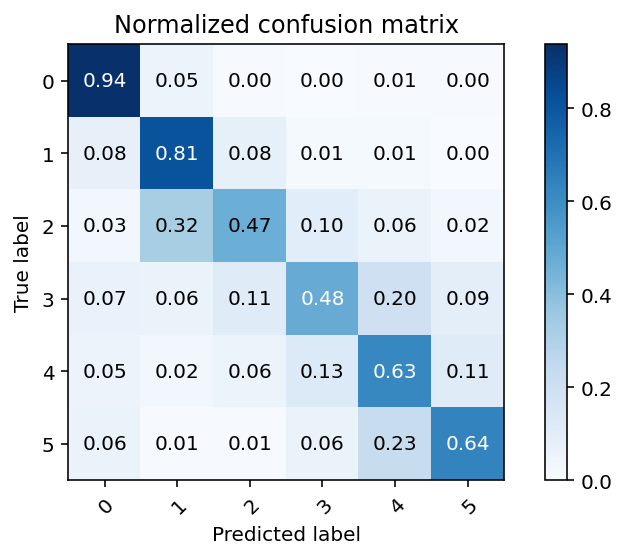

In [40]:
_ = plot_confusion_matrix(val_df.isup_grade, val_df.isup_pred, normalize=True)

In [41]:
pred_kappa = cohen_kappa_score(val_df.isup_grade, val_df.isup_pred, weights="quadratic")

In [42]:
pred_kappa

0.8488472374866902

#### Check results with Hard Class Permutation

In [43]:
hard_cls_values = val_df.loc[val_df.isup_pred.isin([2,3,4]), "isup_pred"].copy().values

In [44]:
hard_cls_values[:5]

array([4, 3, 4, 2, 3])

In [45]:
np.random.shuffle(hard_cls_values)

In [46]:
hard_cls_values[:5]

array([3, 4, 3, 4, 2])

In [47]:
val_df.loc[val_df.isup_pred.isin([2,3,4]), "isup_pred"] = hard_cls_values

Normalized confusion matrix
[[0.94382022 0.03792135 0.00702247 0.00421348 0.00280899 0.00421348]
 [0.0830721  0.79937304 0.03605016 0.04702194 0.03291536 0.0015674 ]
 [0.04126984 0.27936508 0.25396825 0.22222222 0.18412698 0.01904762]
 [0.09310345 0.05862069 0.26896552 0.23793103 0.24482759 0.09655172]
 [0.0652921  0.03780069 0.26460481 0.25429553 0.2371134  0.14089347]
 [0.05818182 0.01454545 0.11636364 0.10545455 0.14909091 0.55636364]]


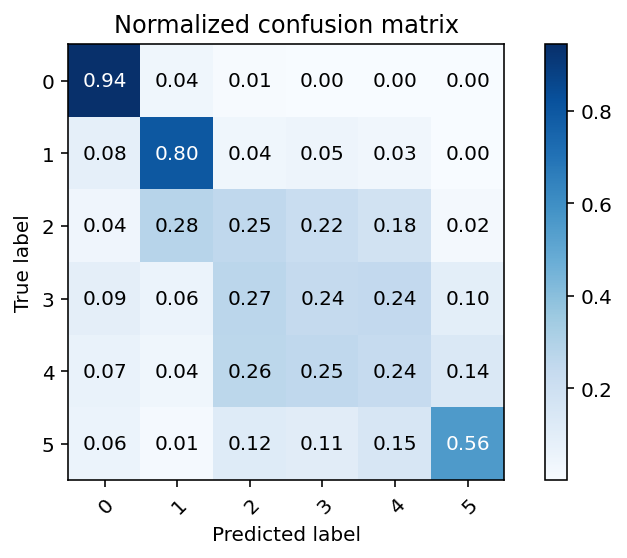

In [48]:
_ = plot_confusion_matrix(val_df.isup_grade, val_df.isup_pred, normalize=True)

In [49]:
permute_kapa = cohen_kappa_score(val_df.isup_grade, val_df.isup_pred, weights="quadratic")
permute_kapa

0.7659439769237075

In [50]:
print(f"Permutation importance: {1 - (permute_kapa/pred_kappa)}")

Permutation importance: 0.07017338008015972


In [34]:
# LB
print(f"LB Permutation importance: {1 - (0.80/0.84)}")

LB Permutation importance: 0.04761904761904756
